# Risk Models Using Tree-based Models

In [7]:
# import shap
import sklearn
import itertools
import pydotplus
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image

from sklearn.tree import export_graphviz, DecisionTreeClassifier
from six import StringIO
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer

from assignments.C2_W2.util import load_data, cindex

In [8]:
X_dev, X_test, y_dev, y_test = load_data(10)

R:\Work\Anacond\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25)

In [11]:
X_train.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
4189,43.0,60.0,443.0,1.0,44.3,8.0,4.9,244.0,106.0,1.75,7.1,1.0,NaN,415.0,25.5,6.0,26.036980,50.0
8650,64.0,70.0,60.0,1.0,46.2,6.0,4.0,176.0,70.0,1.64,6.5,1.0,120.0,310.0,22.6,6.6,20.720797,50.0
8536,47.0,60.0,351.0,1.0,46.4,19.0,4.1,171.0,125.0,1.57,6.6,2.0,NaN,338.0,37.0,6.7,23.468758,34.0
1037,49.0,84.0,347.0,1.0,49.1,17.0,4.7,160.0,111.0,1.69,7.0,2.0,NaN,379.0,29.3,6.9,28.626451,36.0
36,74.0,84.0,120.0,1.0,77.7,23.0,4.1,246.0,138.0,1.26,6.8,2.0,178.0,418.0,33.0,4.5,26.216042,94.0


In [12]:
y_train.head(20)

4189    False
8650    False
8536    False
1037    False
36      False
2498    False
9845    False
8724    False
2078    False
7048    False
419     False
2170    False
9897    False
3134    False
8099    False
2871     True
1009     True
562     False
9365    False
838     False
Name: time, dtype: bool

In [13]:
i=20
print(X_train.iloc[i, :])

Age                    39.000000
Diastolic BP           65.000000
Poverty index         192.000000
Race                    1.000000
Red blood cells        36.700000
Sedimentation rate     26.000000
Serum Albumin           4.100000
Serum Cholesterol     208.000000
Serum Iron             47.000000
Serum Magnesium         1.630000
Serum Protein           6.700000
Sex                     2.000000
Systolic BP                  NaN
TIBC                  298.000000
TS                     15.800000
White blood cells       7.700000
BMI                    23.735426
Pulse pressure         40.000000
Name: 2816, dtype: float64


### Dealing with Missing Data

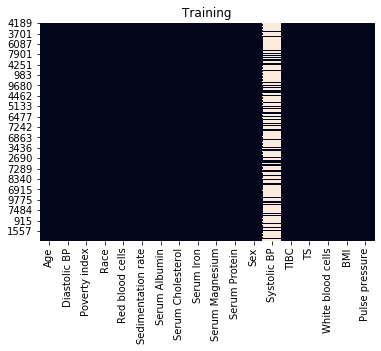

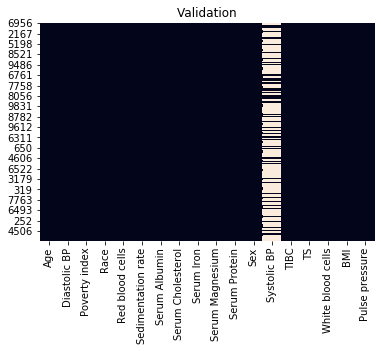

In [14]:
sns.heatmap(X_train.isnull(), cbar=False)
plt.title("Training")
plt.show()

sns.heatmap(X_val.isnull(), cbar=False)
plt.title("Validation")
plt.show()

For each feature, represented as a column, values that are present are shpwn in black, and missing values are set in a light colour.

From this plot, we can see that many values are missing for systolic blood pressure (`Systolic BP`).

In [15]:
def fraction_rows_missing(df):
    frac_missing = df.isnull().sum() / len(df)
    
    return frac_missing

In [17]:
X_train_dropped = X_train.dropna(axis="rows")
y_train_dropped = y_train.loc[X_train_dropped.index]
X_val_dropped = X_val.dropna(axis="rows")
y_val_dropped = y_val.loc[X_val_dropped.index]

### Decision Trees

In [20]:
dt = DecisionTreeClassifier(max_depth=None, random_state=10)
dt.fit(X_train_dropped, y_train_dropped)

DecisionTreeClassifier(random_state=10)

C-index will be used for evaluation for the model.

$$\text{C-Index} = \frac{\#\text{concordant pairs} + 0.5\times \#\text{ties}}{\#\text{permissible pairs}}$$

In [25]:
y_train_preds = dt.predict_proba(X_train_dropped)[:, 1]
print(f"Train C-Index: {cindex(y_train_dropped.values, y_train_preds)}")

y_val_preds = dt.predict_proba(X_val_dropped)[:, 1]
print(f"Train C-Index: {cindex(y_val_dropped.values, y_val_preds)}")

Train C-Index: 1.0
Train C-Index: 0.5478525893796005


In [26]:
dt_hyperparams = {
    "criterion": "entropy",
    "max_depth": 10,
    "min_samples_split": 50
}

In [27]:
dt_reg = DecisionTreeClassifier(**dt_hyperparams)
dt_reg.fit(X_train_dropped, y_train_dropped)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=50)

In [33]:
dot_data = StringIO()
export_graphviz(dt_reg, feature_names=X_train_dropped.columns, out_file=dot_data,
               filled=True, rounded=True, proportion=True, special_characters=True,
               impurity=False, class_names=['neg', 'pos'], precision=2)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

InvocationException: GraphViz's executables not found

#### Random Forest

In [34]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_dropped, y_train_dropped)

RandomForestClassifier()

In [38]:
y_train_rf_preds = rf.predict_proba(X_train_dropped)[:, 1]
print(f"Train C-Index {cindex(y_train_dropped.values, y_train_rf_preds)}")

y_val_rf_preds = rf.predict_proba(X_val_dropped)[:, 1]
print(f"Train C-Index {cindex(y_val_dropped.values, y_val_rf_preds)}")

Train C-Index 1.0
Train C-Index 0.665368690851735


Training a random forest with the default hyperparameters results in a model that has better predictive performance than individual decision trees, but this model is overfitting.

We therefore need to tune (or optimize) the hyperparameters, to find a model that both has good predictive performance and minimizes overfittizng.

The hyperparameters we choose to adjust will bw:
- `n_estimators`: the number of trees used in the forest,
- `max_depth`: the maximum depth of each tree,
- `min_samples_leaf`: the maximum number (if `int`) or proportion (if `float`) of samples in a leaf.

In [47]:
def holdout_grid_search(clf, X_train_hp, y_train_hp, X_val_hp, y_val_hp,
                       hyperparams, fixed_hyperparams):
    best_estimator = None
    best_hyperparams = {}
    
    best_score = 0.0
    
    lists = hyperparams.values()
    
    param_combinations = list(itertools.product(*lists))
    total_param_combinations = len(param_combinations)
    
    for i, params in enumerate(param_combinations, 1):
        param_dict = {}
        for param_index, param_name in enumerate(hyperparams):
            param_dict[param_name] = params[param_index]
            
        estimator = clf(**param_dict, **fixed_hyperparams)
        
        estimator.fit(X_train_hp, y_train_hp)
        
        preds = estimator.predict_proba(X_val_hp)
        
        estimator_score = cindex(y_val_hp, preds[:, 1])
        
        print(f'[{i}/{total_param_combinations}] {param_dict}')
        print(f'Val C-Index: {estimator_score}\n')
        
        if estimator_score >= best_score:
            best_score = estimator_score
            best_estimator = estimator
            best_hyperparams = param_dict
    
    best_hyperparams.update(fixed_hyperparams)
    
    return best_estimator, best_hyperparams

In [48]:
def random_forest_grid_search(X_train_dropped, y_train_dropped, X_val_dropped, y_val_dropped):
    hyperparams = {
        'n_estimators': [1, 3, 5, 7],
        'max_depth': [8, 10, 12, 14],
        'min_samples_leaf': [1, 2, 3],
    }
    
    fixed_hyperparams = {
        'random_state': 10
    }
    
    rf = RandomForestClassifier
    
    best_rf, best_hyperparams = holdout_grid_search(rf, X_train_dropped, y_train_dropped,
                                                   X_val_dropped, y_val_dropped, hyperparams,
                                                   fixed_hyperparams)
    print(f"Best hyperparameters:\n{best_hyperparams}")
    
    y_train_best = best_rf.predict_proba(X_train_dropped)[:, 1]
    print(f"Train C-Index: {cindex(y_train_dropped, y_train_best)}")
    
    y_val_best = best_rf.predict_proba(X_val_dropped)[:, 1]
    print(f"Train C-Index: {cindex(y_val_dropped, y_val_best)}")
    
    best_hyperparams.update(fixed_hyperparams)
    
    return best_rf, best_hyperparams

In [49]:
best_rf, best_hyperparams = random_forest_grid_search(X_train_dropped, y_train_dropped, 
                                                     X_val_dropped, y_val_dropped)

[1/48] {'n_estimators': 1, 'max_depth': 8, 'min_samples_leaf': 1}
Val C-Index: 0.5687598580441641

[2/48] {'n_estimators': 1, 'max_depth': 8, 'min_samples_leaf': 2}
Val C-Index: 0.5966088328075709

[3/48] {'n_estimators': 1, 'max_depth': 8, 'min_samples_leaf': 3}
Val C-Index: 0.5833661934805467

[4/48] {'n_estimators': 1, 'max_depth': 10, 'min_samples_leaf': 1}
Val C-Index: 0.5775253023133544

[5/48] {'n_estimators': 1, 'max_depth': 10, 'min_samples_leaf': 2}
Val C-Index: 0.5693513406940063

[6/48] {'n_estimators': 1, 'max_depth': 10, 'min_samples_leaf': 3}
Val C-Index: 0.5046661409043113

[7/48] {'n_estimators': 1, 'max_depth': 12, 'min_samples_leaf': 1}
Val C-Index: 0.5091269058885384

[8/48] {'n_estimators': 1, 'max_depth': 12, 'min_samples_leaf': 2}
Val C-Index: 0.5663035620399579

[9/48] {'n_estimators': 1, 'max_depth': 12, 'min_samples_leaf': 3}
Val C-Index: 0.5694827812828601

[10/48] {'n_estimators': 1, 'max_depth': 14, 'min_samples_leaf': 1}
Val C-Index: 0.5360722266035752

[1

In [50]:
y_test_best = best_rf.predict_proba(X_test)[:, 1]

print(f"Test C-Index: {cindex(y_test.values, y_test_best)}")

Test C-Index: 0.6398295430572549


### Imputation

You've now built and optimized a random forest model on the data.

However there was still a drop in the C-index. This might be because you threw away more than a half of the data because of missing values for systolic blood pressure. Instead we can try filling in, ir **imputing** these values.

Let's explore to see if our data is missing at random or not.

Let's plot the histograms of the dropped rows against each of the convariates (aside from systolic blood pressure) to see, if there is a trend. Compare these to the histograms of the feature in the entire dataset. Try to see if one of the covariates has a significantly different distribution in the two subsets.

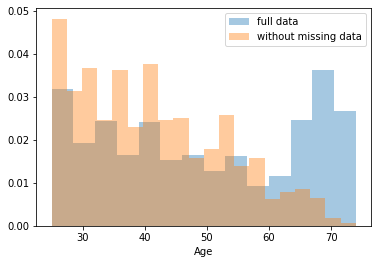

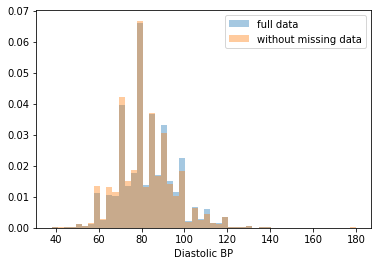

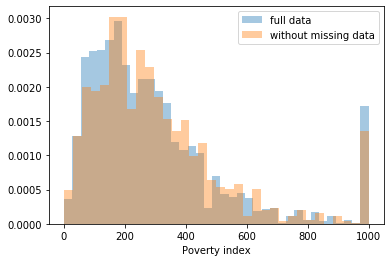

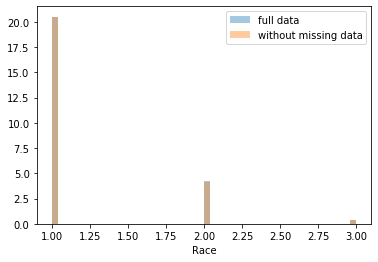

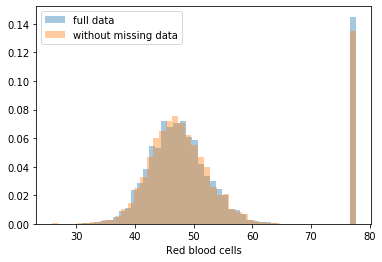

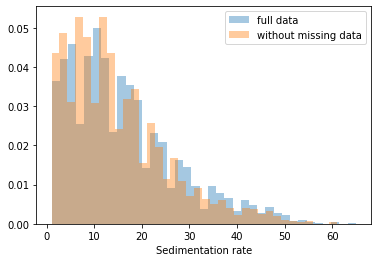

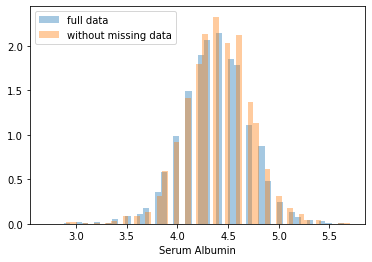

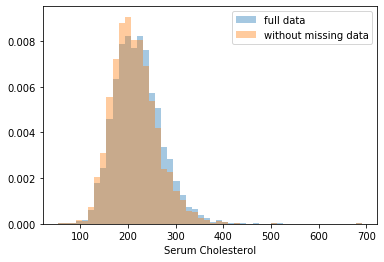

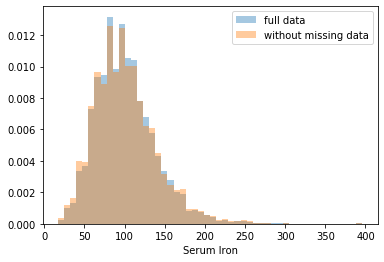

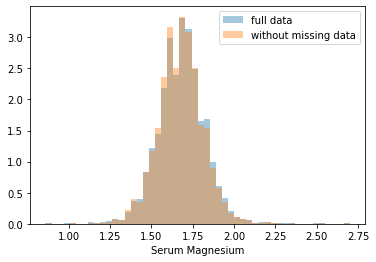

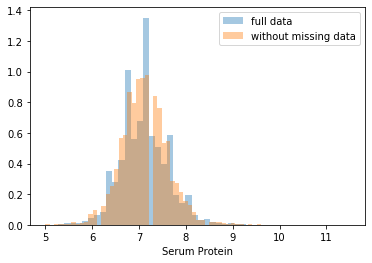

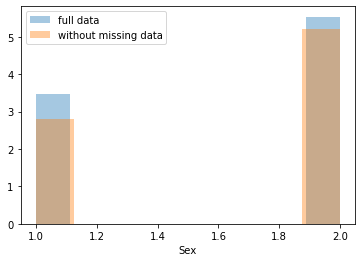

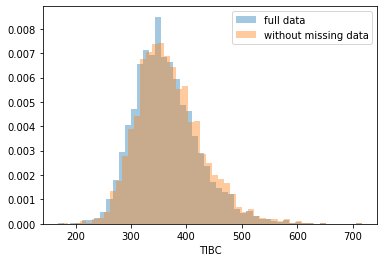

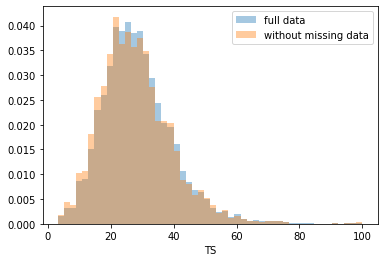

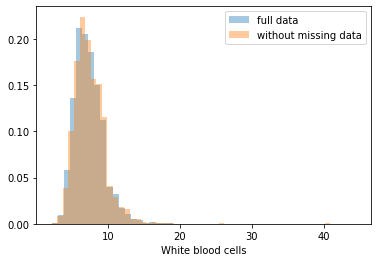

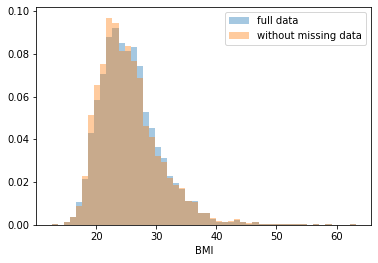

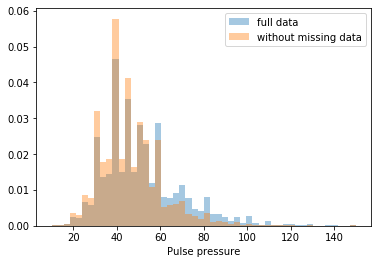

In [53]:
dropped_rows = X_train[X_train.isnull().any(axis=1)]

columns_except_Systolic_BP = [col for col in X_train.columns if col not in ['Systolic BP']]

for col in columns_except_Systolic_BP:
    sns.distplot(X_train.loc[:, col], norm_hist=True, kde=False, label="full data")
    sns.distplot(dropped_rows.loc[:, col], norm_hist=True, kde=False, label="without missing data")
    plt.legend()
    
    plt.show()

Most of the covariates are distributed similarly wheter or not we have discarded rows with missing data. In other words missingness of the data is independent of these covariates.

If this had been true across all covariates, then the data would have been said to be **missing completely at random (MCAR)**.



But when considering the age covariate, we see that much more data tends to be missing for patients over 65. The reason could be that blood pressure was measured less frequently for old people to avoid placing additional burden on them.

As missingness is related to one or more covariates, the missing data is said to be **missing at random (MAR)**.



Based on the information we have, there is however no reason to belive that the *values* of the missing data - or specifically the values of the missing ayatoic blood pressures - are related to the age of the patients. If this was the case, then this data would be said to be **missing not at random (MNAR)**.

#### Error Analysis

In [54]:
def bad_subset(forest, X_test, y_test):
    mask = X_test["Race"] == 2
    
    X_subgroup = X_test[mask]
    y_subgroup = y_test[mask]
    subgroup_size = len(X_subgroup)
    
    y_subgroup_preds = forest.predict_proba(X_subgroup)[:, 1]
    performance = cindex(y_subgroup.values, y_subgroup_preds)
    
    return performance, subgroup_size

In [56]:
performance, subgroup_size = bad_subset(best_rf, X_test, y_test)
print("Subgroup size should greater than 250, performance should be less than 0.69 ")
print(f"Subgroup size: {subgroup_size}, C-Index: {performance}")

Subgroup size should greater than 250, performance should be less than 0.69 
Subgroup size: 273, C-Index: 0.6135525260625502


### Imputation Approaches

Seeing that our data is not missing completely at random, we can handlle the missing values by replacing them with substituted values based on the other values that we have. This is known as imputation.

The first imputation strategy that we will use is **mean substitution**: we will replace the missing values for each feature with the mean of the available values.

In [57]:
imputer = SimpleImputer(strategy="mean")
imputer.fit(X_train)
X_train_mean_imputed = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_val_mean_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

In [58]:
hyperparams = {
    'n_estimators': [7, 10, 12],
    'max_depth': [15, 20, 25],
    'min_samples_leaf': [3, 4, 5, 6, 7]
}

In [61]:
rf = RandomForestClassifier

rf_mean_imputed, best_hyperparams_mean_imputed = holdout_grid_search(rf, X_train_mean_imputed, y_train,
                                                                    X_val_mean_imputed, y_val,
                                                                    hyperparams, {"random_state": 10})
print("Performance for best hyperparameters:")

y_train_best = rf_mean_imputed.predict_proba(X_train_mean_imputed)[:, 1]
print(f"- Train C-Index: {cindex(y_train, y_train_best):.4f}")

y_val_best = rf_mean_imputed.predict_proba(X_val_mean_imputed)[:, 1]
print(f"- Train C-Index: {cindex(y_val, y_val_best):.4f}")

y_test_imp = rf_mean_imputed.predict_proba(X_test)[:, 1]
print(f"- Train C-Index: {cindex(y_test, y_test_imp):.4f}")

[1/45] {'n_estimators': 7, 'max_depth': 15, 'min_samples_leaf': 3}
Val C-Index: 0.7223237120935331

[2/45] {'n_estimators': 7, 'max_depth': 15, 'min_samples_leaf': 4}
Val C-Index: 0.7305120881862819

[3/45] {'n_estimators': 7, 'max_depth': 15, 'min_samples_leaf': 5}
Val C-Index: 0.7516909202705473

[4/45] {'n_estimators': 7, 'max_depth': 15, 'min_samples_leaf': 6}
Val C-Index: 0.739200611315576

[5/45] {'n_estimators': 7, 'max_depth': 15, 'min_samples_leaf': 7}
Val C-Index: 0.7280536817059804

[6/45] {'n_estimators': 7, 'max_depth': 20, 'min_samples_leaf': 3}
Val C-Index: 0.7072758583815286

[7/45] {'n_estimators': 7, 'max_depth': 20, 'min_samples_leaf': 4}
Val C-Index: 0.7344765053423278

[8/45] {'n_estimators': 7, 'max_depth': 20, 'min_samples_leaf': 5}
Val C-Index: 0.7473188108753576

[9/45] {'n_estimators': 7, 'max_depth': 20, 'min_samples_leaf': 6}
Val C-Index: 0.7436796563800494

[10/45] {'n_estimators': 7, 'max_depth': 20, 'min_samples_leaf': 7}
Val C-Index: 0.7439514512061453



In [62]:
imputer = IterativeImputer(sample_posterior=False, max_iter=1, min_value=0)
imputer.fit(X_train)
X_train_imputed = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

R:\Work\Anacond\lib\site-packages\sklearn\impute\_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [63]:
hyperparams = {
    'n_estimators': [5, 7, 9, 11],
    'max_depth': [15, 20, 25, 30],
    'min_samples_leaf': [6, 8, 10, 12]
}

In [64]:
rf = RandomForestClassifier

rf_imputed, best_hyperparams_imputed = holdout_grid_search(rf, X_train_imputed, y_train,
                                                          X_val_imputed, y_val,
                                                          hyperparams, {'random_state': 10})
print("Performance for best hyperparameters:")
y_train_best = rf_imputed.predict_proba(X_train_imputed)[:, 1]
print(f"Train C-Index: {cindex(y_train, y_train_best):.4f}")

y_val_best = rf_imputed.predict_proba(X_val_imputed)[:, 1]
print(f"Train C-Index: {cindex(y_val, y_val_best):.4f}")

y_test_imp = rf_imputed.predict_proba(X_test)[:, 1]
print(f"Train C-Index: {cindex(y_test, y_test_imp):.4f}")

[1/64] {'n_estimators': 5, 'max_depth': 15, 'min_samples_leaf': 6}
Val C-Index: 0.6929386813049716

[2/64] {'n_estimators': 5, 'max_depth': 15, 'min_samples_leaf': 8}
Val C-Index: 0.7157215484284912

[3/64] {'n_estimators': 5, 'max_depth': 15, 'min_samples_leaf': 10}
Val C-Index: 0.7373804771113112

[4/64] {'n_estimators': 5, 'max_depth': 15, 'min_samples_leaf': 12}
Val C-Index: 0.7146689004339806

[5/64] {'n_estimators': 5, 'max_depth': 20, 'min_samples_leaf': 6}
Val C-Index: 0.7208188153310104

[6/64] {'n_estimators': 5, 'max_depth': 20, 'min_samples_leaf': 8}
Val C-Index: 0.7118885730326064

[7/64] {'n_estimators': 5, 'max_depth': 20, 'min_samples_leaf': 10}
Val C-Index: 0.7279901886523432

[8/64] {'n_estimators': 5, 'max_depth': 20, 'min_samples_leaf': 12}
Val C-Index: 0.7327488259354643

[9/64] {'n_estimators': 5, 'max_depth': 25, 'min_samples_leaf': 6}
Val C-Index: 0.7215116693549106

[10/64] {'n_estimators': 5, 'max_depth': 25, 'min_samples_leaf': 8}
Val C-Index: 0.7087996916688

### Comparison

In [65]:
performance, subgroup_size = bad_subset(best_rf, X_test, y_test)
print(f"C-Index (no imputation): {performance}")

performance, subgroup_size = bad_subset(rf_mean_imputed, X_test, y_test)
print(f"C-Index (mean imputation): {performance}")

performance, subgroup_size = bad_subset(rf_imputed, X_test, y_test)
print(f"C-Index (multivariate feature imputation): {performance}")

C-Index (no imputation): 0.6135525260625502
C-Index (mean imputation): 0.7157979149959903
C-Index (multivariate feature imputation): 0.703047313552526


### Explainations: SHAP

In [68]:
X_test_risk = X_test.copy(deep=True)
X_test_risk.loc[:, 'risk'] = rf_imputed.predict_proba(X_test_risk)[:, 1]
X_test_risk = X_test_risk.sort_values(by="risk", ascending=False)
X_test_risk.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,risk
2608,71.0,80.0,104.0,1.0,43.8,23.0,4.0,201.0,119.0,1.60,7.0,1.0,166.0,311.0,38.3,6.3,17.760766,86.0,0.696229
2400,70.0,80.0,312.0,1.0,54.8,7.0,4.4,222.0,52.0,1.57,7.2,1.0,180.0,417.0,12.5,7.5,45.770473,100.0,0.693601
864,74.0,110.0,105.0,1.0,46.9,45.0,4.4,233.0,102.0,1.70,7.3,1.0,180.0,283.0,36.0,9.2,26.906341,70.0,0.691379
621,71.0,80.0,93.0,1.0,51.5,21.0,4.4,256.0,81.0,1.90,6.7,1.0,160.0,418.0,19.4,8.9,35.038705,80.0,0.677164
1940,71.0,105.0,155.0,1.0,46.4,21.0,4.2,243.0,88.0,1.50,7.2,1.0,160.0,417.0,21.1,10.5,27.601637,55.0,0.665760


In [70]:
import shap

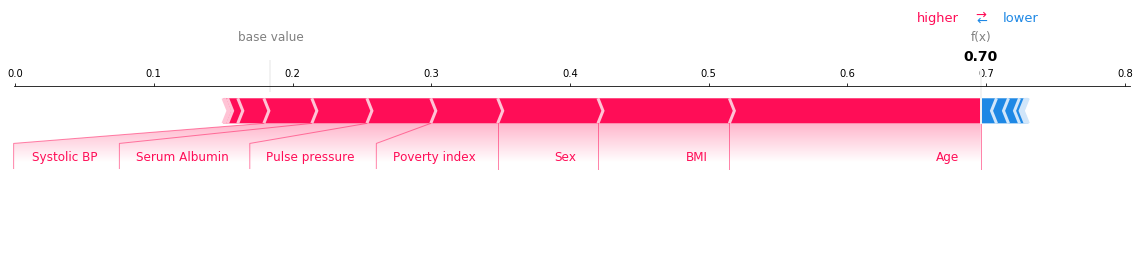

In [72]:
explainer = shap.TreeExplainer(rf_imputed)
i = 0
shap_value = explainer.shap_values(X_test.loc[X_test_risk.index[i], :])[1]
shap.force_plot(explainer.expected_value[1], shap_value, feature_names=X_test.columns, matplotlib=True)

- The red sectioons on the left are features which push the model towards the final prediction in the positive direction (i.e. higher Age increases the predicted risk).
- The blue sections on the right are features that push the model towards the final prediction in the negative direction (if an increase in a feature leads to a lower risk, it will be shown in blue).
- Note that the exact output of your chart will differ depending on the hyper-parameters that you choose for your model.

In [73]:
shap_values = shap.TreeExplainer(rf_imputed).shap_values(X_test)[1]

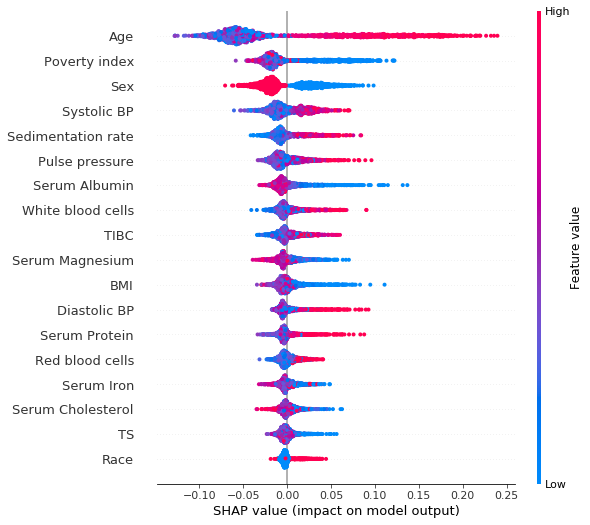

In [74]:
shap.summary_plot(shap_values, X_test)

Clearly we see that being a womn (`sex = 2.0`, as opposed to men for which `sex = 1.0`) has a negative SHAP value, meaning that it reduces the risk of dying within 10 years. High age and high systolic blood pressure have positive SHAP values, and are therefore related to increased mrtality.

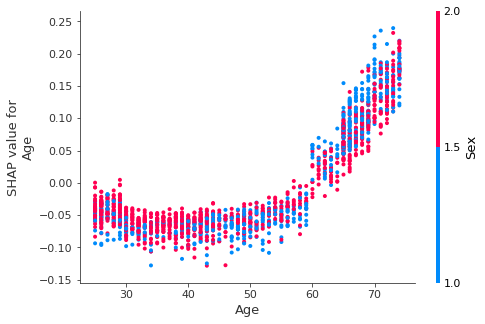

In [75]:
shap.dependence_plot('Age', shap_values, X_test, interaction_index='Sex')


You see that while Age > 50 is generally bad (positive SHAP value), being a woman generally reduces the impact of age. This makes sense since we know that women generally live longer than men.

Let's nw look at poverty index and age.

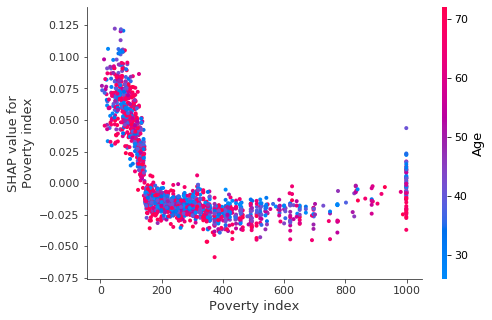

In [76]:
shap.dependence_plot("Poverty index", shap_values, X_test, interaction_index="Age")